In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_pose.postprocess.projected_gd import ProjectedGD
from torchtyping import TensorType
from omegaconf import DictConfig
from lightning_pose.utils.scripts import get_imgaug_transform, get_dataset, get_data_module, get_loss_factories
from lightning_pose.utils.io import return_absolute_data_paths
import hydra
import os
import pandas as pd
import cvxpy as cp
from PIL import Image

In [2]:
def get_base_config(config_dir: str, config_name: str) -> DictConfig:
    assert(os.path.isdir(config_dir))
    hydra.initialize_config_dir(base_config_dir)
    cfg = hydra.compose(config_name="config")
    return cfg
from typing import List
def get_keypoint_names(csv_data: pd.DataFrame, header_rows: List[int]) -> List[str]:
    if header_rows == [0,1,2]:
        keypoint_names = [c[1] for c in csv_data.columns[1::2]]
    elif header_rows == [1,2]:
        keypoint_names = [c[0] for c in csv_data.columns[1::2]]
    return keypoint_names

In [3]:
def toy_func(x=2,y=1) -> float:
    return x**2 + y**2

In [6]:
toy_func(**{"x":2, "y":2})

8

In [3]:
dataset_name = "rick-configs-1"
# dataset_name = "ibl-pupil-2"
# dataset_name = "ibl-paw-2"
base_config_dir = "/home/jovyan/rick-configs-1"
base_save_dir = "/home/jovyan/"

# hydra.initialize_config_dir(base_config_dir)
# cfg = hydra.compose(config_name="config")
cfg = get_base_config(base_config_dir, "config")



In [4]:
# load ground truth labels
csv_file = os.path.join(cfg.data.data_dir, cfg.data.csv_file)
csv_data = pd.read_csv(csv_file, header=list(cfg.data.header_rows))
keypoints_gt = csv_data.iloc[:, 1:].to_numpy().reshape(csv_data.shape[0], -1, 2)

keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)

In [16]:
# save_dir = os.path.join(base_save_dir, dataset_name)
save_dir = "/home/jovyan/lightning-pose"

loss_type = "pca_singleview" # Change for different loss functions
error_metric = "reprojection_error" # for pca only
# define models
to_compute = "rmse" # rmse | pca_multiview | pca_singleview | unimodal_mse
model_name = "supervised-heatmap-75"
train_frames = 1 # used to be 75 # 000
#pca_singleview_epsilon = 15.
#pca_multiview_epsilon = None
#empirical_epsilon_multiplier = 1.0 # can hack this if want to sweep over multipliers/losses
model_type = "heatmap"
#rng_seed = 42
# temporal_epsilon = 9.8 # hack for now
#loss_weight_dict['pca_singleview'].sort(reverse=True)

pca_loss = None
datamodule = None
model_cfg = cfg.copy()
model_cfg.training.train_frames = train_frames
model_cfg.model.losses_to_use = [loss_type]
from lightning_pose.utils.pca import KeypointPCA
data_dir, video_dir = return_absolute_data_paths(data_cfg=model_cfg.data)
imgaug_transform = get_imgaug_transform(cfg=model_cfg)
dataset = get_dataset(cfg=model_cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)
data_module = get_data_module(cfg=model_cfg, dataset=dataset, video_dir=video_dir)
data_module.setup()
# compute pca params
loss_factories = get_loss_factories(cfg=model_cfg, data_module=data_module)
pca_loss = loss_factories["unsupervised"].loss_instance_dict[loss_type]
# store results here
if to_compute == "pca_singleview":
    # remove obstacle keypoints
    keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]
    print(keypoint_names)

metrics_collected = {bp: [] for bp in keypoint_names}
cols_collected = []

Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 836, val set: 104, test set: 105
Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 836, val set: 104, test set: 105


[/opt/dali/dali/operators/reader/loader/video_loader.h:178] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.354 0.247 0.17  0.063 0.056 0.031 0.02  0.015 0.008 0.008 0.008 0.005
 0.004 0.003 0.002 0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.992


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:327: UserWarning: Using empirical epsilon=0.158 * multiplier=1.000 -> total=0.158 for pca_singleview loss
  warnings.warn(


In [17]:
cum_sum_explained_variance = np.cumsum(pca_loss.pca.pca_object.explained_variance_ratio_)

/tmp/ipykernel_23307/366790639.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("/home/jovyan/" + save_name, figsize=(10,8), dpi=300)


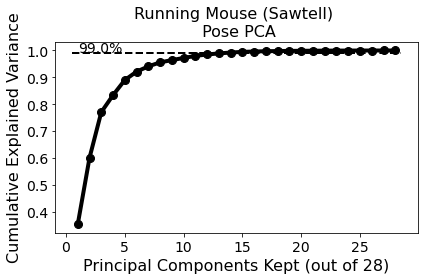

In [18]:
dataset_name = "Running Mouse (Sawtell)"
loss_type = "Pose PCA"
save_name = "single_pca_participation_ratio.png"
fraction_to_keep = 0.99
num_total_comps = cum_sum_explained_variance.shape[0]
plt.plot(np.arange(1, num_total_comps+1), cum_sum_explained_variance, marker="o", color = "black", linewidth=4, markersize=8)
plt.hlines(y=fraction_to_keep, xmin=1-.5, xmax=cum_sum_explained_variance.shape[0]+.5, color = "black", linestyles="dashed", linewidth=2)
plt.text(1.0, fraction_to_keep+0.002, f"{fraction_to_keep*100}%", fontsize=14)
plt.xlabel("Principal Components Kept (out of %i)" % cum_sum_explained_variance.shape[0], fontsize=16)
plt.ylabel("Cumulative Explained Variance", fontsize=16)
plt.title(f"{dataset_name} \n {loss_type}", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
if loss_type == "Multiview PCA":
    plt.xticks(np.arange(1, num_total_comps+1));
plt.tight_layout()
plt.savefig("/home/jovyan/" + save_name, figsize=(10,8), dpi=300)

In [8]:
# make a dataframe for plotly
num_total_comps = cum_sum_explained_variance.shape[0]
d = {"explained_variance":cum_sum_explained_variance, "num_components":np.arange(1, num_total_comps+1)}
df = pd.DataFrame(data=d)


In [15]:
# make a nicer line plot in plotly
import plotly.express as px
dataset_name = "Running Mouse (Sawtell)"
loss_type = "Pose PCA" #"Pose PCA"
fig = px.line(df, x="num_components", y="explained_variance", title=f"{dataset_name} \n {loss_type}")
fig.show()

In [18]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.num_components, y=df.explained_variance,
                    mode='lines+markers'))
                

In [ ]:
loss_type